# Word of God

Jack Carter - 11/10/2022

## Summary

This project uses machine learning assess whether extreme rhetoric can be succesfully predicted from high profile individuals in the Muslim world. Potential applications could include an initial warning (with a lot of additional human based follow up needed) against extremist rhetoric among radical preachers.

## 1) Data Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

# creates a risks data set with extremist related quotes. 
extreme = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/Word-of-God/Data/extremist_rhetoric.xlsx')

# creates a risks data set with non-extremist related quotes. 
not_extreme = pd.read_excel('C:/Users/HUAWEI/Desktop/Projects/Word-of-God/Data/non_extremist_rhetoric.xlsx')

# combines the extremist and non-extremist quotes. 
combined_df = pd.concat([extreme, not_extreme]).reset_index(drop = True)

# views sample headlines. 
combined_df.head(4)

,name,label,statement,source
0,Osama bin Laden,extremist,Our terrorism against America is blessed terrorism.,https://abcnews.go.com/International/story?id=80278&page=1
1,Osama bin Laden,extremist,"God willing, America's end is near. And it doesn't depend on my continued existence. Whether Osama is killed or not, the awakening has begun.",https://abcnews.go.com/International/story?id=80278&page=1
2,Osama bin Laden,extremist,How is it right for you to occupy our countries and kill our women and children and expect to live in peace and security? … the equation is clear: you are killed as you kill and abducted as you abduct.,https://www.theguardian.com/world/2011/may/02/bin-laden-war-words-quotes
3,Osama bin Laden,extremist,"God willing, our raids on you will continue as long as your support to the Israelis will continue.",https://www.theguardian.com/world/2011/may/02/bin-laden-war-words-quotes


In [2]:
# prints the number of extremist vs moderate quotes. 
extremist_len = len(combined_df[combined_df.label=='extremist'])
moderate_len = len(combined_df[combined_df.label!='extremist'])

print('Extremist: ' + str(extremist_len) + ' (' + str(round((extremist_len / (extremist_len + moderate_len))* 100, 1)) + '%)')
print('Moderate: ' + str(moderate_len) + ' (' + str(round((moderate_len / (extremist_len + moderate_len))* 100, 1)) + '%)')

Extremist: 29 (19.1%)
Moderate: 123 (80.9%)


In [3]:
# splits the data into training and test sets. 
x = combined_df.statement
y = np.where(combined_df.label=='extremist', 1, 0)

# splits the data into training and test sets. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2017)

# prints the number number of statements in each set. 
for dataset in [x_train, x_test]:
    print('Dataset has {}{} of the data.'.format((round(len(dataset) / len(combined_df), 2))*100, '%'))

Dataset has 80.0% of the data.
Dataset has 20.0% of the data.


In [4]:
# 'fit_on_texts' assigns a unique number for each word in our vocab.
# 'texts_to_sequences' replaces each headline with a number sequence. 
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# views a sample sequence:
x_train_seq[0]

[3, 15, 223, 5, 3, 15, 6, 224, 17, 1, 408]

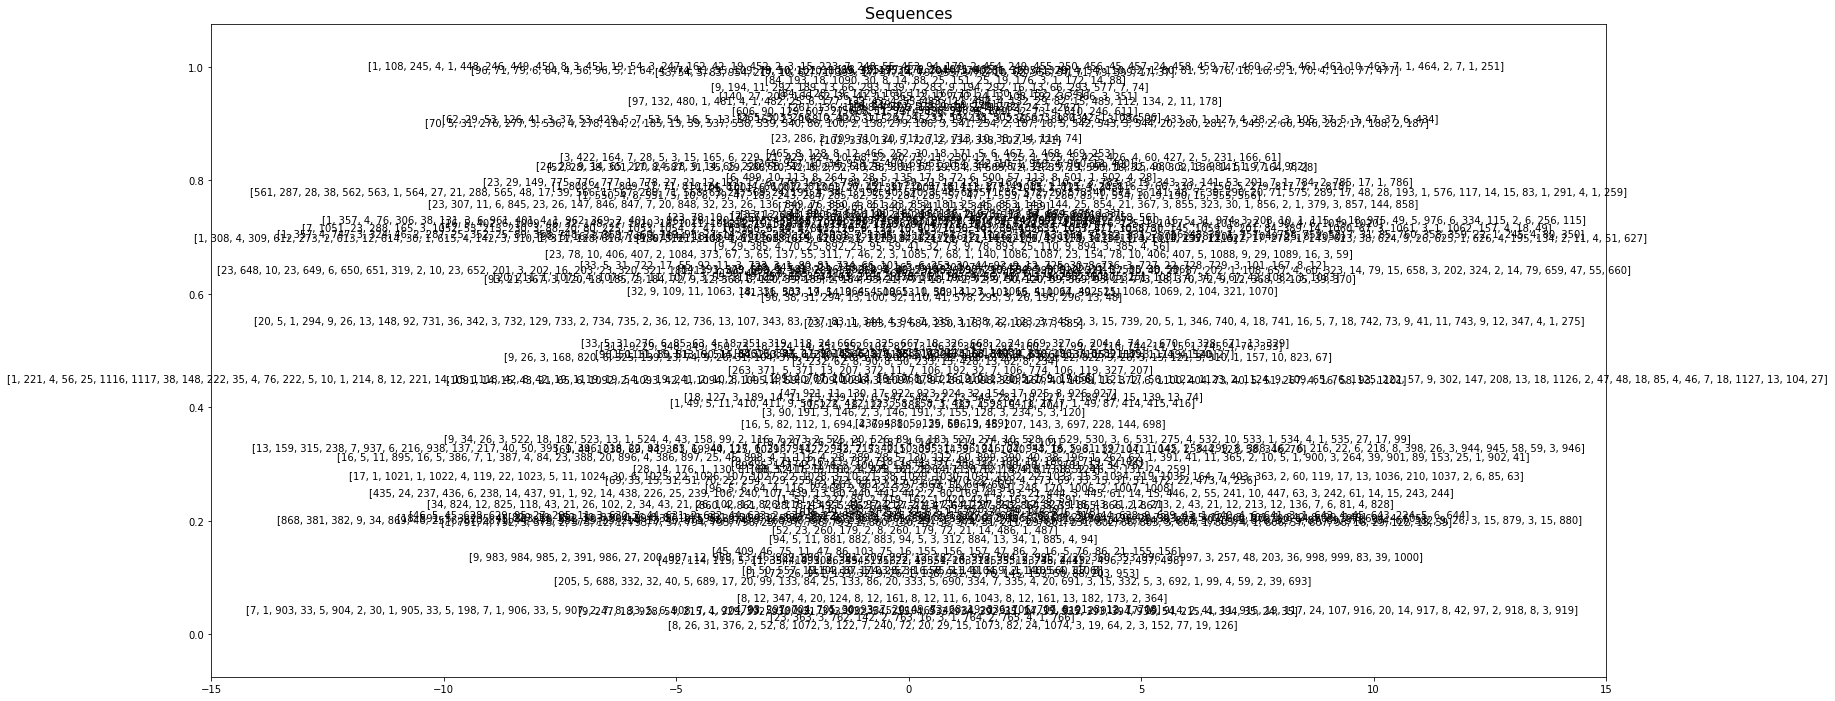

In [5]:
# imports matplotlib
import matplotlib.pyplot as plt

# creates a scatterplot of the text sequences. 
x = np.random.random(len(x_train_seq))
y = np.random.random(len(x_train_seq))
txt = x_train_seq

fig, axes = plt.subplots(figsize=(25,12))
axes.scatter(x, y, s=0.01)
axes.set_xlim(-15, 15)
axes.set_ylim(-0.075, 1.075)
for i, txt in enumerate(txt):
    axes.annotate(text=txt, xy=(x[i], y[i]), ha='center')
plt.title('Sequences', size=16)
plt.show()

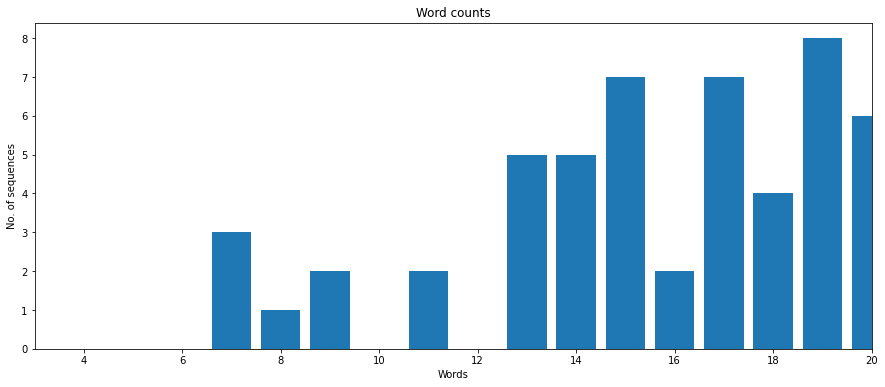

In [6]:
# creates a barplot of the sequence word counts. 
from collections import Counter

lengths = []

for i in range(len(x_train_seq)):
    lengths.append(len(x_train_seq[i]))
    
words_df = pd.DataFrame()
words_df['words'] = list(Counter(lengths).keys())
words_df['frequency'] = list(Counter(lengths).values())
words_df.sort_values('words')

fig, axes = plt.subplots(figsize=(15,6))
axes.bar(list(words_df['words']), list(words_df['frequency']))

plt.xlabel('Words')
plt.ylabel('No. of sequences')
plt.xlim(3,20)
plt.title('Word counts')
plt.show()

In [7]:
# 'pad_sequences' adds zeros to begining of all sequences untill each is equal to our max length (50).
# this is needed to ensure we have matrices of the same length later on in the process. 
x_train_seq_padded = pad_sequences(x_train_seq, 50)
x_test_seq_padded = pad_sequences(x_test_seq, 50)

# view a sample padded sequence:
x_train_seq_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         3,  15, 223,   5,   3,  15,   6, 224,  17,   1, 408])

## 2) Training

In [8]:
# imports functions and defines two functions to test recall and precision.  
import keras.backend as K
from keras import layers
from keras.layers import Dense, Embedding, Conv1D, LSTM
from keras.models import Sequential

epochs = 14

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision

def m_compile(model):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision, recall])
    
def m_fit(model):
    history = model.fit(x_train_seq_padded, y_train, 
                    batch_size=32, epochs=epochs,
                    validation_data=(x_test_seq_padded, y_test))
    return history

In [9]:
# builds a simple fnn model with several layers. 
fnn = Sequential()
fnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
fnn.add(layers.GlobalMaxPooling1D())
fnn.add(Dense(32, activation='relu'))
fnn.add(Dense(1, activation='sigmoid'))
fnn.summary()

# compiles the model. 
m_compile(fnn)

# fits the model. 
fnn_history = m_fit(fnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          36512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37,601
Trainable params: 37,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
4/4 [==============================] - 1s 81ms/step - loss: 0.6829 - accuracy: 0.7686 - precision: 0.0000e+

In [10]:
# builds a simple cnn model with several layers. 
cnn = Sequential()
cnn.add(layers.Embedding(len(tokenizer.index_word)+1, 50, input_length=50))
cnn.add(layers.Conv1D(32, 8, activation='relu'))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(10, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

# compiles the model. 
m_compile(cnn)

# fits the model. 
cnn_history = m_fit(cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            30750     
                                                                 
 conv1d (Conv1D)             (None, 43, 32)            12832     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 43,923
Trainable params: 43,923
Non-trainable params: 0
__________________________________________________

In [10]:
# builds a simple rnn model with several layers. 
rnn = Sequential()
rnn.add(Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=32))
rnn.add(LSTM(32, dropout=0.25, recurrent_dropout=0.25))
rnn.add(Dense(32, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

# compiles the model. 
m_compile(rnn)

# fits the model. 
rnn_history = m_fit(rnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          36512     
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 45,921
Trainable params: 45,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
4/4 [==============================] - 3s 124ms/step - loss: 0.6893 - accuracy: 0.7355 - precision: 0.0500 - recall: 0.0357 - val_loss: 0.6725 - val_accuracy: 0.9677 - val